# [Tutorial Link](https://towardsdatascience.com/time-series-prediction-beyond-test-data-3f4625019fd9)

In [1]:
%config Completer.use_jedi = False

In [2]:
import math
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt 
import mplfinance as mpf
plt.style.use('fivethirtyeight')

In [3]:
df = yf.download("^BSESN")
dataset = df.filter(['Close'])
print(len(df))
dataset.head()

[*********************100%***********************]  1 of 1 completed
5908


,Close
Date,
1997-07-01,4300.859863
1997-07-02,4333.899902
1997-07-03,4323.459961
1997-07-04,4323.819824
1997-07-07,4291.450195


D:\CondaEnvironments\money_manager\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


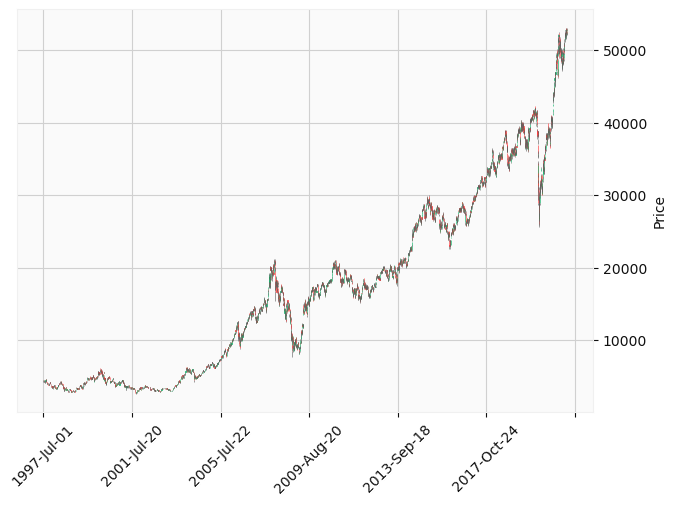

In [4]:
mpf.plot(df, type="candle", style="yahoo")

In [5]:
scalar = MinMaxScaler(feature_range=(0, 1))
train = scalar.fit_transform(dataset)

In [30]:
n_input = 300
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=128, sampling_rate=1,stride=1)

In [31]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(generator,epochs=1,verbose=1)

44/44 [==============================] - 70s 2s/step - loss: 0.0730 - accuracy: 1.7832e-04


In [32]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input): 
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
# pred_list

In [33]:
add_dates = [df.index[-1] + pd.DateOffset(days=x) for x in range(0,n_input+1) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)
# future_dates[-n_input:].index.is_unique
# future_dates.drop_duplicates(inplace=True)
future_dates

,Open,High,Low,Close,Adj Close,Volume
2021-07-07,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-08,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-09,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-10,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-11,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-04-28,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-29,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_predict = pd.DataFrame(scalar.inverse_transform(pred_list), index=future_dates[-n_input:].index, columns=['Prediction'])
df_proj = pd.concat([df['Close'],df_predict], axis=1)
# df_proj

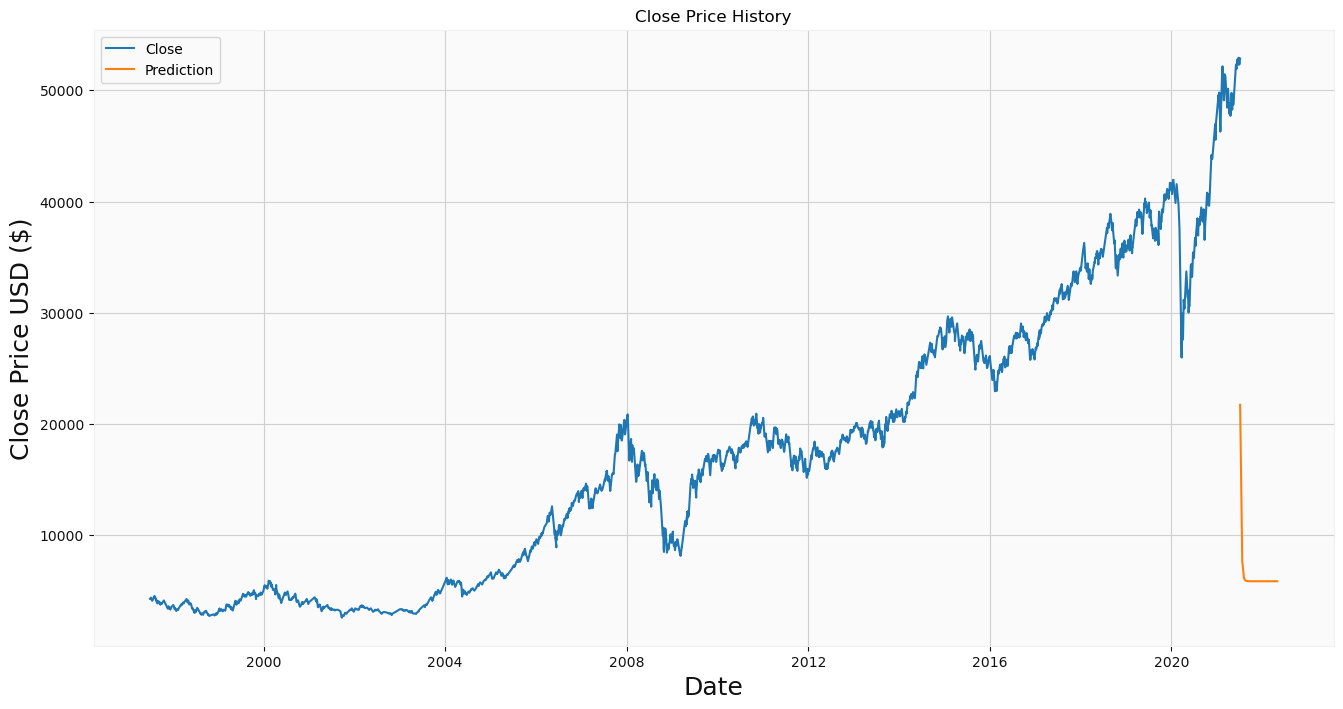

In [35]:
plt.figure(figsize=(16, 8))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.plot(df_proj[['Prediction']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Close', 'Prediction'])